# 4.1 Corner detection and description

Keypoint detection is the searching of "interesting" pixels (or points) in images. There are different types of keypoints: corners, blobs, edges, ridges, ...  
Now, we will focus on corner detection. A corner is a point with high variation of intensity in 2 spatial directions.

This notebook is covering corner detection using **Harris corner detector**. Also, a keypoint descriptor  is needed in order to match keypoints between images, we will use normalized cross-correlation.

## Problem context - Image stitching

Image stitching or photo stitching is the process of combining multiple photographic images with overlapping fields of view to produce a segmented panorama or high-resolution image:

<img src="./images/stitching.jpg" width="600">

Feature detection is necessary to find correspondences between images. Robust correspondences are required in order to estimate the necessary transformation to align an image with the image it is being composited on. 

Our task in this notebook is to develop the first step in this process. This lies in developing a robust point matching between overlapping images.

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
images_path = './images/'

Before starting to work, you will have to complete some explained exercises in order to familiarize with Harris corner detector.

As usual, **display testing image** `car.jpeg`.

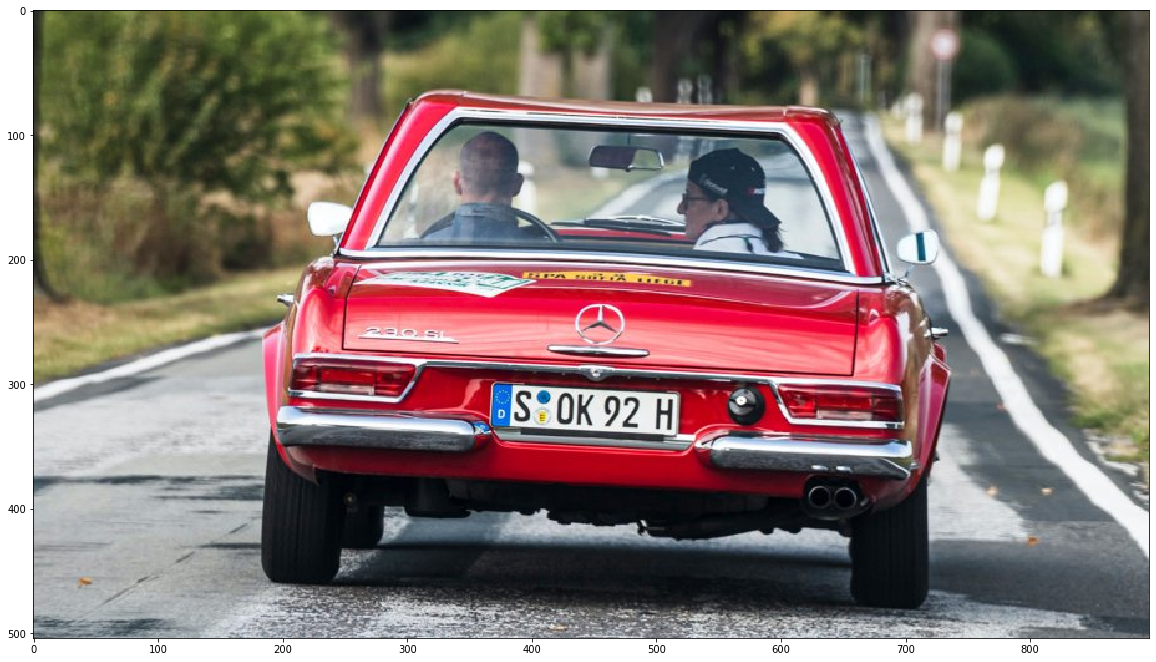

In [20]:
# Read image
image = cv2.imread(images_path + 'car.jpeg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Show it
plt.imshow(image)

### Harris corner detector

First, let's remind how Harris works:

The main idea is to construct a matrix M that differences between pixels that are corners and pixels that are not,
this can be done using image derivatives (e.g. Sobel) and Gaussian smoothing:

$$M = \begin{bmatrix}
\sum_{W} g\oplus I_x^2 & \sum_{W}{g\oplus(I_x I_y)}\\
\sum_{W}{g\oplus(I_xI_y)} & \sum_{W}{g\oplus(I_y^2)}
\end{bmatrix}$$

Being W a gaussian window, $I_x$ and $I_y$ image derivatives, and $g$ gaussian kernel. $\\[10pt]$

<img src="./images/harris.png" width="600">$\\[5pt]$

Then, to distinguish corners $R$ is calculated:

$$R = det M - k (trace M)^2$$

- $R$ is large and positive at corners
- $R$ is negative at edges
- $R$ is small at flat regions 

*Mention that whole math process is in chapter 3 theory* $\\[10pt]$


Harris detector is already implemented in openCV as [cv2.cornerHarris](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornerharris), main inputs are:


- **src**: input gray image
- **block_size**: size of Gaussian window
- **ksize**: size of the sobel filter used (natual odd)
- **k**: empiric constant (usually 0.04-0.06)

**What to do?** Calcule $R$ image using Harris and display it.

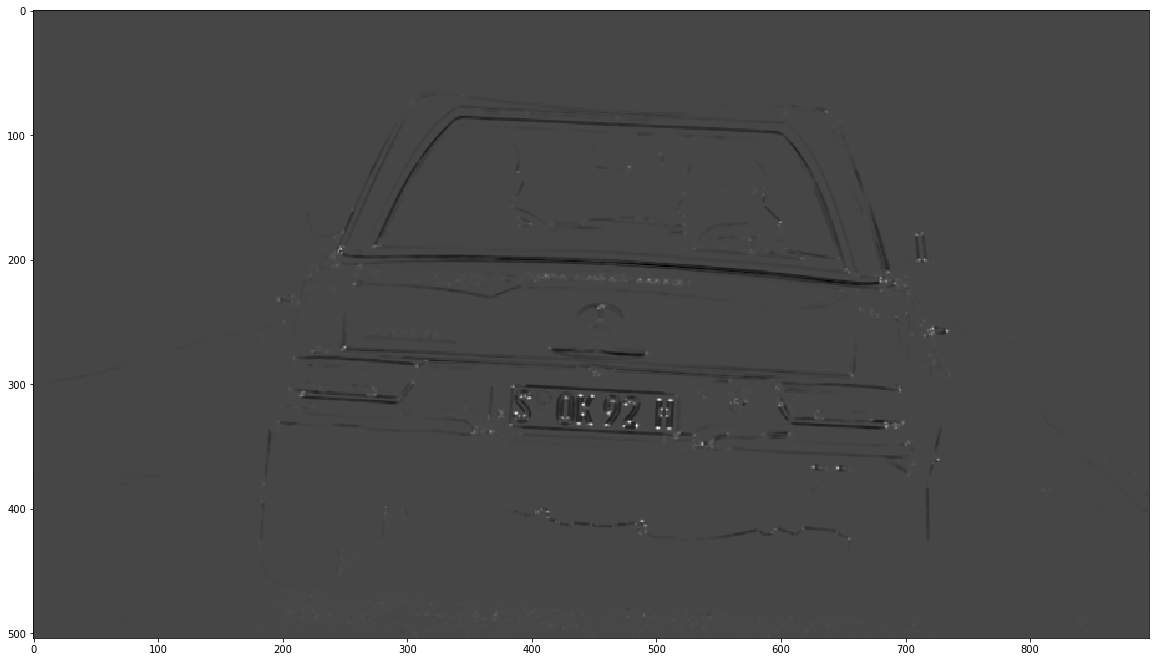

In [21]:
# Convert to gray
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Size of Sobel kernel
size_sobel = 3

#Empiric constant K
const_k = 0.05

# Size of Gaussian window (in openCV neighbor averaging)
size_window = 3

# Apply Harris
harris = cv2.cornerHarris(gray,size_window,size_sobel,const_k)

#  Show R image
plt.imshow(harris, cmap='gray')

As told before, you sould see a gray image where borders are black, corners are white and flat surfaces are gray.

**You have to** play with input parameters and **answer following questions**:

- What happens if W size is 1?
- What happens if W is large? (*note that `cv2.cornerHarris` uses neighborhood averaging instead of gaussian*)


Next, **you will have to** find pixels where $R$ is high ($R >$ threshold).  
But... what are the maximum and minimum values in $R$ image? Print them.

In [22]:
print("Max: " , harris.max(), "\nMin: ", harris.min())

Max:  0.023417622 
Min:  -0.008977413


Are those values the same for different images or input parameters?  

**No**, they are not. As they change, it is necessary to define the threshold over the maximum value in image (in this way we skip normalization).  

**What to do?** Display the binarized image using a threshold that you think is great.

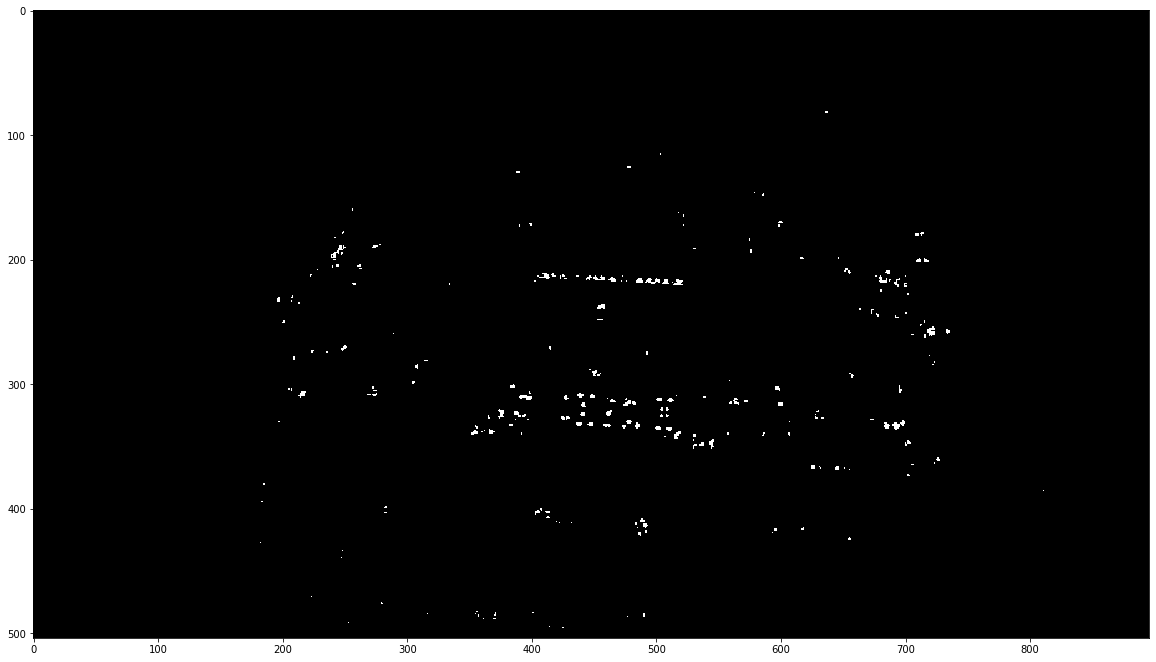

In [23]:
threshold = 0.05*harris.max()

_, corners = cv2.threshold(harris,threshold,1,cv2.THRESH_BINARY)
plt.imshow(corners, cmap='gray')

As we are looking for points, binarized image is not valid because it has many responses for  the same point. A solution is applying **non-maximum suppression** to those clusters of points, keeping only a point for each of them.$\\[10pt]$

<img src="./images/nonmax.png" width="600">$\\[5pt]$

To simplify this, `nonmaxsuppts` is provided:  
In order to pick up the optimal values to indicate corners, we find the local maxima as corners within a window.

In [31]:
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppersion.   
    
        Args:
            cim: harris 'R' image
            radius: aperture size of local maxima window
            thresh: threshold value
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

openCV defines a set of functions for drawing objects about feature detection. An example is [cv2.drawKeypoints](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433), which given an image and a list of [cv2.KeyPoint](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html) objects, it draws them on the output image (third input argument).

This implies the transformation of `r` and `c` to a `cv2.KeyPoint` list. *Tip: [rows and columns to KeyPoint list ideas](https://www.programcreek.com/python/example/77058/cv2.KeyPoint)*

**What to do?** Apply non-maxima suppression to harris '$R$' image and draw the keypoints detected on the image.

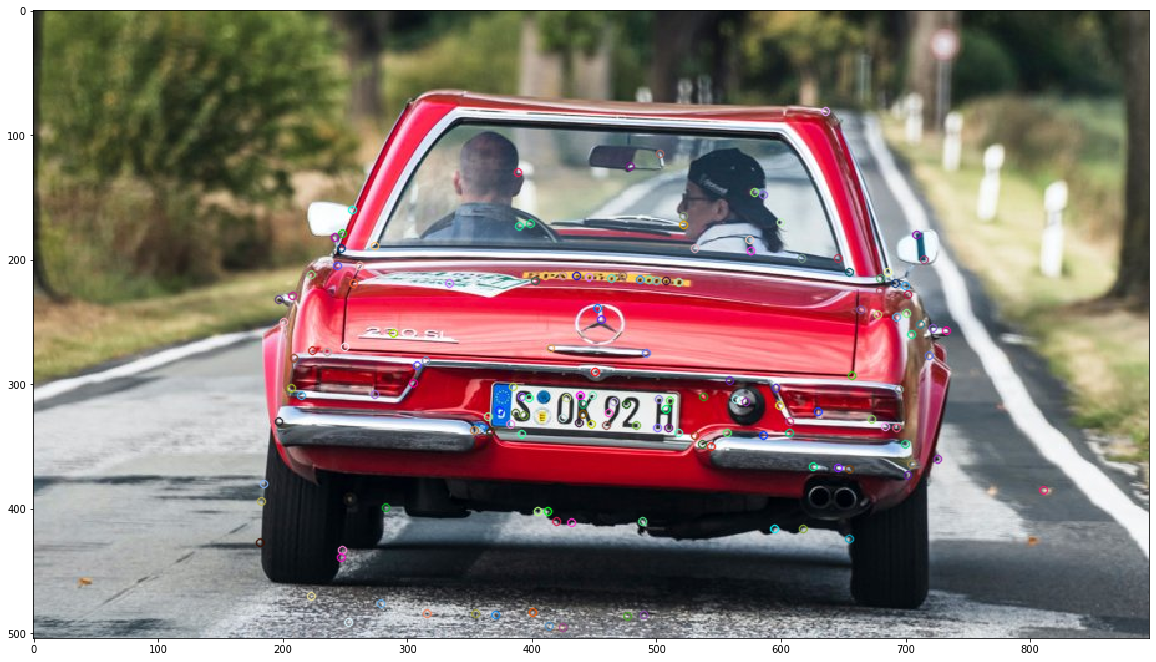

In [25]:
radius_non_maxima = 5

# Apply non maxima supression
r,c = nonmaxsuppts(harris, radius_non_maxima, threshold)

# Convert coordinates to cv2.KeyPoint list
kps = [cv2.KeyPoint(c[i], r[i], 2) for i in range(len(r))]

# Draw keypoints
image_corners = np.copy(image)
cv2.drawKeypoints(image,kps,image_corners)

# Show image with corners
plt.imshow(image_corners)

### Keypoint description through NCC

One important thing to understand is that after extracting the keypoints, you only obtain information about their position. While the information about keypoint position might sometimes be useful, it does not say much about the keypoints themselves. Usually you need to know how different or similar one keypoint is to the other.

This is where **normalized cross-correlation** (NCC) appears, a way to describe how similar are two keypoints.  
NCC cross-correlation is just like convolution, a sliding window (the template) operating over an image. The difference between CC and convolution is that in CC the kernel is not flipped. Normalized CC means that the results are normalized in order to being invariant to changes in brightness and constrast.$\\[5pt]$

<img src="./images/ncc_convolution.jpg" width="400">$\\[5pt]$

openCV defines [cv2.matchTemplate](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html?highlight=matchtemplate)(image, template, cv2.TM_CCORR_NORMED), that apply NCC of `template` over `image`.

This code will help you to understand how NCC works.   
- **Review it and try to explain what is done here** (you can modify `p_index` and `w_temp` parameters).

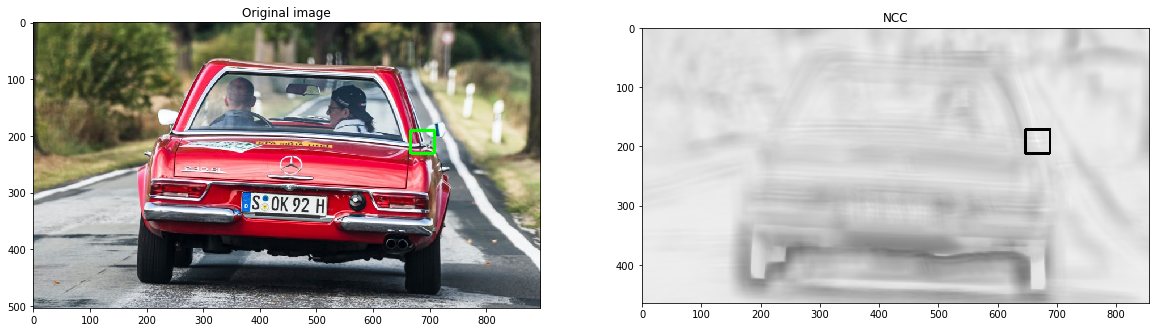

In [26]:
# Index of the focusing point
p_index = 26

# NCC window aperture
w_temp = 20

# Construct NCC window
p_r, p_c = r[p_index], c[p_index]
template = image[p_r-w_temp:p_r+w_temp+1,p_c-w_temp:p_c+w_temp+1]

# Calcule NCC image
ncc = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)

# Search maximum in NCC
p_x, p_y = p_c, p_r
[max_y, max_x] = np.where(ncc == np.amax(ncc))

# Draw rectangle in matching points
image_draw = np.copy(image)
ncc_draw = np.copy(ncc)

cv2.rectangle(image_draw,(p_x-w_temp,p_y-w_temp),(p_x+w_temp+1,p_y+w_temp+1),(0,255,0),3)
cv2.rectangle(ncc_draw,(max_x-w_temp,max_y-w_temp),(max_x+w_temp+1,max_y+w_temp+1),0,3)

# Show original image
plt.subplot(121)
plt.imshow(image_draw)
plt.title('Original image')

# Show NCC image
plt.subplot(122)
plt.imshow(ncc_draw, cmap='gray')
plt.title('NCC')
plt.show()

Now, **answer following questions**:

- Describe `p_index` and `w_temp`
- What represents NCC image?
- What would happen if `template` were taken from a similar (but not the same) image?

# Time to work: matches between images with overlapping field 

It is time to apply what have been learn during this notebook. Coming back to image stitching, **it is asked to you** to compute matches between two images with overlapping field. The images are  `park_l.jpeg` (left) and `park_r.jpeg` (right). 

**It is asked to use Harris corner detector and NCC descriptor**. Also, you will have to draw keypoints and matches using [cv2.drawMatches](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1), it takes two images, two lists of `cv2.KeyPoint` objects and a list of [cv2.DMatch](https://docs.opencv.org/3.4/d4/de0/classcv_1_1DMatch.html) objects as input. To create a `cv2.DMatch` object it is used   
`cv2.DMatch(idx_l, idx_r,1)`, being `idx_l` and `idx_r` the indices of the keypoints being matched.

*Tip: [drawing functions documentation](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html)* 

Results should look like this (output of `cv2.drawMatches`):

<img src="./images/index.png" width="1000">

Lets do this step by step:  
**What to do?**

- Use harris corner detector to get the keypoints of both images
- Convert them to two lists of `cv2.KeyPoint` objects

In [28]:
# Aperture size of NCC window
w_temp = 20

# Read images
image_l = cv2.imread(images_path + 'park_l.jpeg')
image_r = cv2.imread(images_path + 'park_r.jpeg')
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)
image_r = cv2.cvtColor(image_r,cv2.COLOR_BGR2RGB)

# Get gray images
image_l_gray = cv2.cvtColor(image_l,cv2.COLOR_RGB2GRAY)
image_r_gray = cv2.cvtColor(image_r,cv2.COLOR_RGB2GRAY)

# Compute corners
harris_l = cv2.cornerHarris(image_l_gray,2,3,0.05)
harris_r= cv2.cornerHarris(image_r_gray,2,3,0.05)

# Apply non maximum supression
r_l,c_l = nonmaxsuppts(harris_l, 3, 0.1*harris_l.max())
r_r,c_r = nonmaxsuppts(harris_r, 3, 0.1*harris_r.max())

# Convert coordinates to cv2.KeyPoint list
kps_l = [cv2.KeyPoint(c_l[i], r_l[i], 1) for i in range(len(r_l))]
kps_r = [cv2.KeyPoint(c_r[i], r_r[i], 1) for i in range(len(r_r))]


In order to ensure that window is not going to access out of image limits (e.g. keypoint at (0,0)), add padding to images using  
[cv2.copyMakeBorder](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=copymakeborder#void%20copyMakeBorder(InputArray%20src,%20OutputArray%20dst,%20int%20top,%20int%20bottom,%20int%20left,%20int%20right,%20int%20borderType,%20const%20Scalar&%20value)) (`cv2.BORDER_REFLECT` is the best padding option in this case)

In [29]:
# Apply border reflect padding to images
image_l_pad = cv2.copyMakeBorder(image_l, w_temp, w_temp, w_temp, w_temp, cv2.BORDER_REFLECT)
image_r_pad = cv2.copyMakeBorder(image_r, w_temp, w_temp, w_temp, w_temp, cv2.BORDER_REFLECT)

- For each keypoint in left image
    - Take a template over that point
    - Apply ncc using that template over right image
    - If there are robustness (ncc max value grater than 0.95), find the matching keypoint in right image. Then, define the `cv2.DMatch` object
- Once all matches are defined, call `cv2.drawMatches` and display the resultant image

Be careful with the number of keypoints detected, as it could take a time to process all of them.

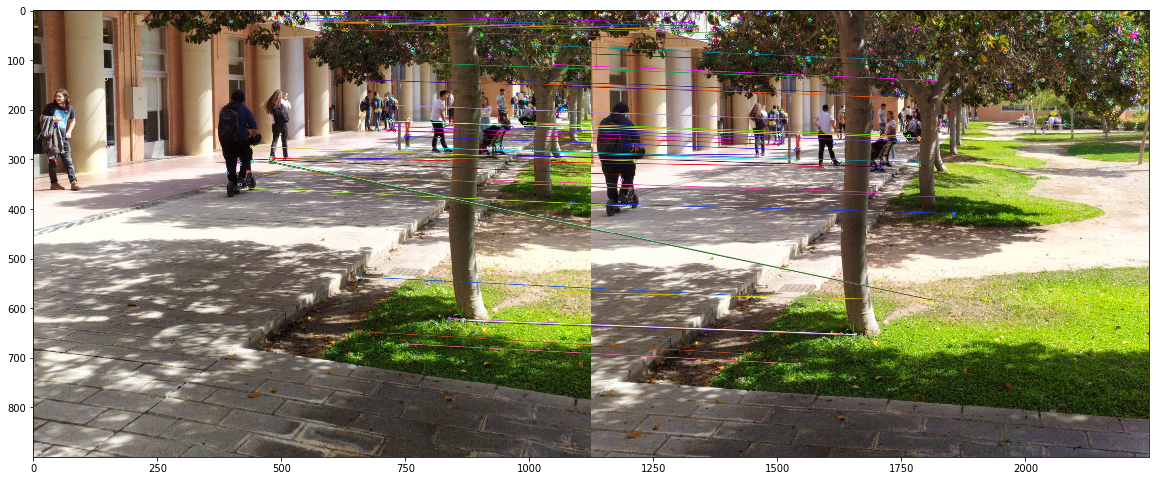

In [32]:
# Initialize matches list
matches = []

# For each keypoint in left image
for p_index in range(len(r_l)):
    
    # Calcule template
    p_r, p_c = r_l[p_index]+w_temp, c_l[p_index]+w_temp
    template = image_l_pad[p_r-w_temp:p_r+w_temp+1,p_c-w_temp:p_c+w_temp+1]
    
    # Compute NCC of the left keypoint in right image
    ncc = cv2.matchTemplate(image_r_pad, template, cv2.TM_CCORR_NORMED)
    
    # Find max value in NCC
    max_value = np.amax(ncc[r_r,c_r])
    
    # If match is good
    if max_value > 0.95:
        # Include in match list
        [max_index] = np.where(ncc[r_r,c_r] == max_value)
        matches.append((p_index, max_index))

# Cast matches list to cv2.DMatch list
matches = np.asarray(matches)
matches = [cv2.DMatch(matches[i,0], matches[i,1],1) for i in range(matches.shape[0])]

# Draw matches
image_matches = np.copy(image_l)
image_matches = cv2.drawMatches(image_l,kps_l,image_r,kps_r,matches,image_matches)

# And show them
plt.imshow(image_matches)

## Conclusion

This was a hard work, but finally you made it! In this notebook you have learned to

- detect corners using Harris detector
- match corners using NCC descriptor
- develop the first steps for a image stitching system